Successfully loaded 9260 rows from 2025-09-19_20-36-07_full.network
Found 137 unique GBK identifiers.
Max observed distance: 1.0
Replacing infinite distances with: 1.1
Performing hierarchical clustering using 'average' method...
Clustering complete.


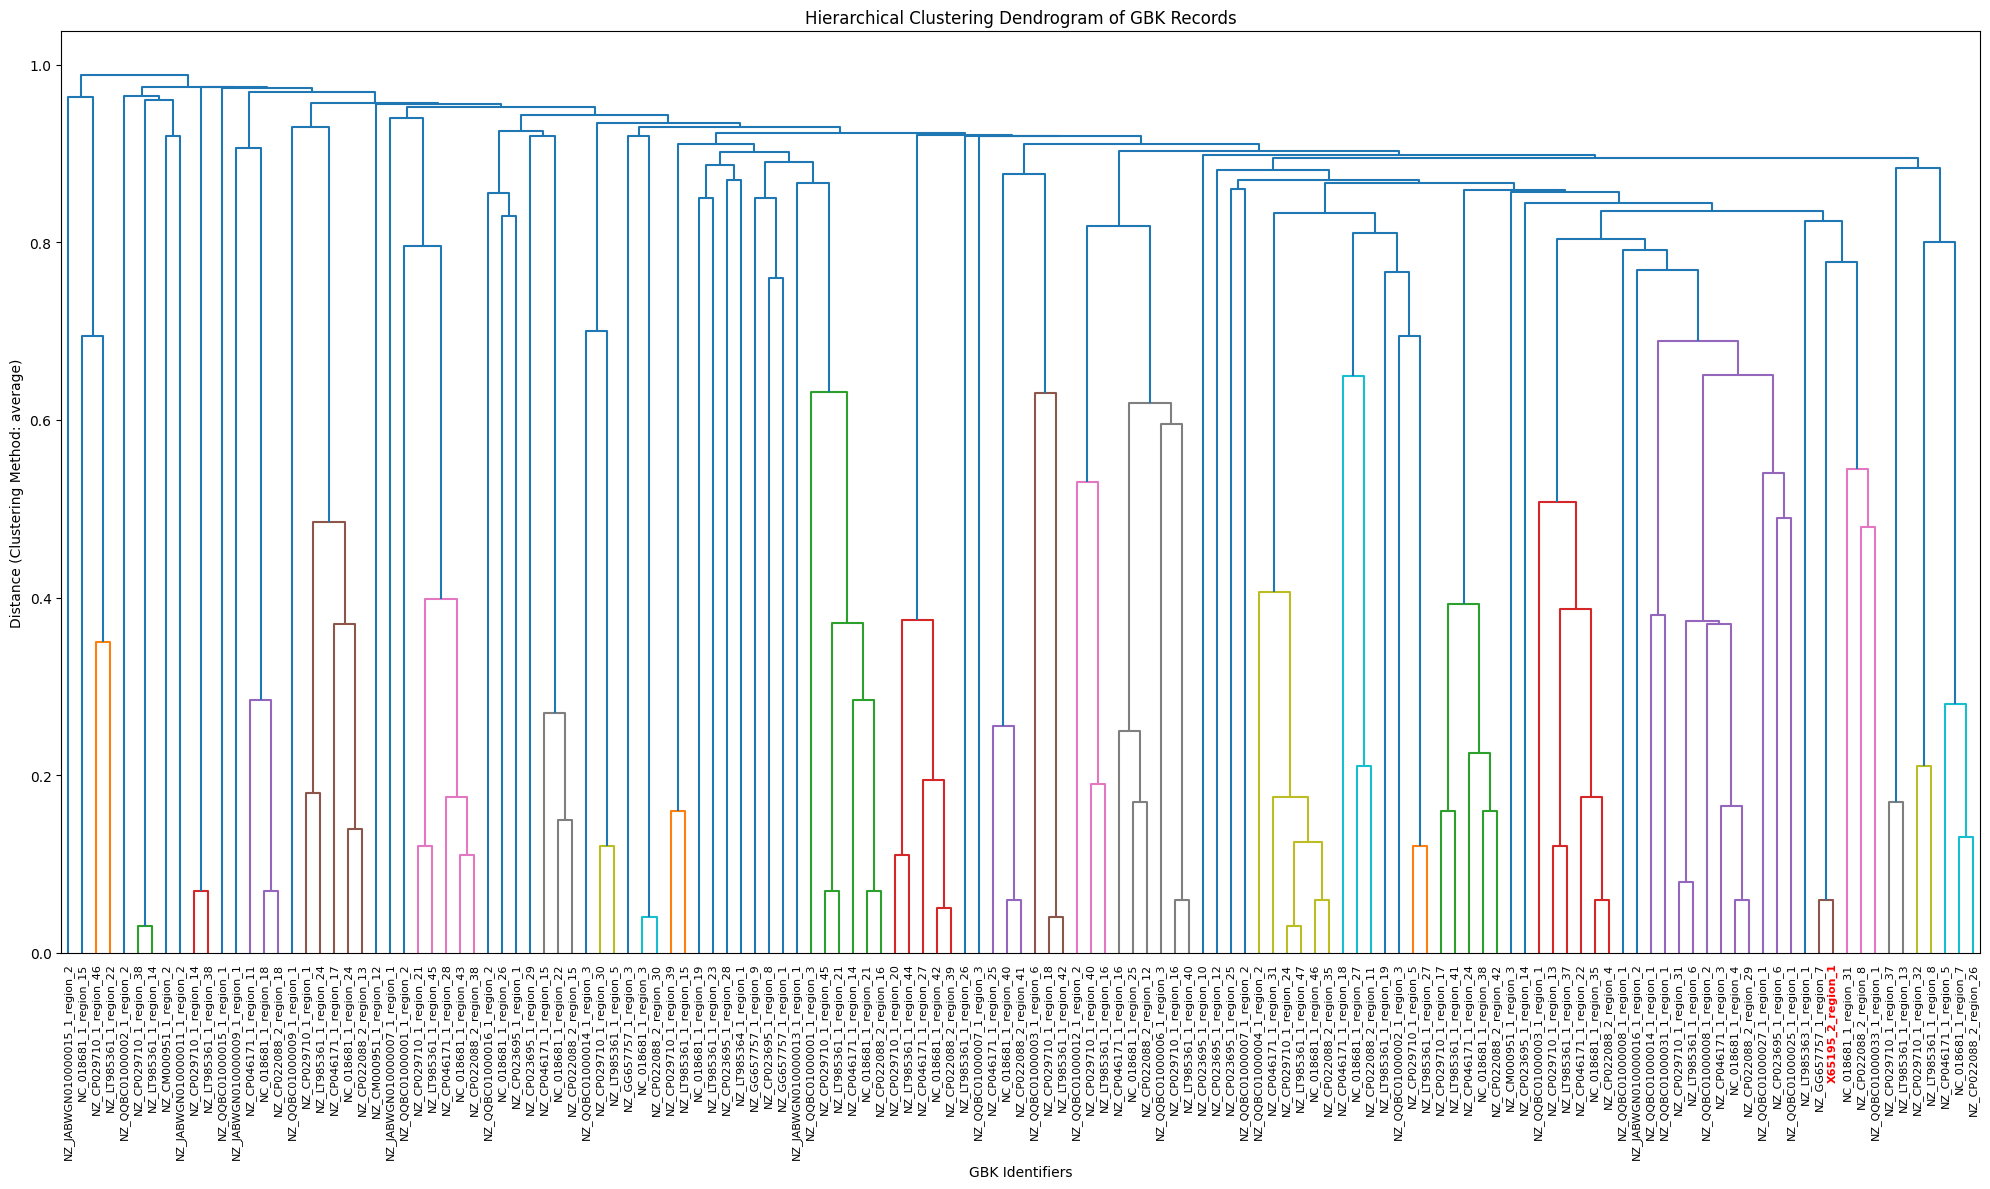

Dendrogram plotted successfully.


In [12]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

# --- Configuration ---
file_path = "2025-09-19_20-36-07_full.network"
distance_column = 'distance'
clustering_method = 'average' # Can be 'single', 'complete', 'average', 'ward', etc.
                            # 'average' is a good general-purpose method.
                            # 'ward' is often good but works best with Euclidean distances.

# --- Label to highlight ---
highlight_label = 'X65195_2_region_1'

# --- 1. Read the TSV file ---
try:
    df = pd.read_csv(file_path, sep='\t')
    print(f"Successfully loaded {len(df)} rows from {file_path}")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please make sure the file is in the same directory as the script or provide its full path.")
    exit()
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    exit()

# --- 2. Identify unique GBK identifiers ---
# Collect all unique GBK names from both 'GBK_a' and 'GBK_b'
gbk_a_labels = df['GBK_a'].unique()
gbk_b_labels = df['GBK_b'].unique()
unique_gbks = np.unique(np.concatenate((gbk_a_labels, gbk_b_labels)))
num_gbks = len(unique_gbks)

print(f"Found {num_gbks} unique GBK identifiers.")

# Create a mapping from GBK label to an integer index
gbk_to_idx = {gbk: i for i, gbk in enumerate(unique_gbks)}

# --- 3. Construct a full distance matrix ---

# Determine a replacement value for infinite distances.
# This will be slightly larger than the maximum observed distance.
max_observed_distance = df[distance_column].max()
# Choose a finite value for unobserved distances.
# If max_observed_distance is 0, this might indicate an issue or a very specific dataset;
# a value > 0 is still needed for 'inf' replacement.
if max_observed_distance == 0:
    inf_replacement_value = 1.0
else:
    inf_replacement_value = max_observed_distance * 1.1

print(f"Max observed distance: {max_observed_distance}")
print(f"Replacing infinite distances with: {inf_replacement_value}")

# Initialize a square matrix with our chosen finite replacement value for non-existent connections
distance_matrix = np.full((num_gbks, num_gbks), inf_replacement_value)
np.fill_diagonal(distance_matrix, 0) # Distance from an item to itself is 0

# Populate the distance matrix using the data from the DataFrame
for _, row in df.iterrows():
    gbk1 = row['GBK_a']
    gbk2 = row['GBK_b']
    dist = row[distance_column]

    idx1 = gbk_to_idx[gbk1]
    idx2 = gbk_to_idx[gbk2]

    # Ensure distances are symmetric
    distance_matrix[idx1, idx2] = dist
    distance_matrix[idx2, idx1] = dist

# --- Convert the square matrix to a condensed distance vector ---
condensed_distances = squareform(distance_matrix)

# --- 4. Perform hierarchical clustering ---
print(f"Performing hierarchical clustering using '{clustering_method}' method...")
Z = linkage(condensed_distances, method=clustering_method)
print("Clustering complete.")

# --- 5. Plot the dendrogram ---
plt.figure(figsize=(20, 12))

# Call dendrogram and capture its output to modify labels
R = dendrogram(
    Z,
    labels=unique_gbks,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

# --- Highlight the specific label ---
# Get the current axes
ax = plt.gca()

if highlight_label in unique_gbks: # Check if the label actually exists
    for leaf_label_obj in ax.get_xticklabels():
        if leaf_label_obj.get_text() == highlight_label:
            leaf_label_obj.set_color('red')
            leaf_label_obj.set_weight('bold')
            # Optional: You can also make it slightly larger for more emphasis
            # leaf_label_obj.set_fontsize(10)
            break # Stop once the label is found and modified
else:
    print(f"Warning: The label '{highlight_label}' was not found in the unique GBK identifiers.")


plt.title('Hierarchical Clustering Dendrogram of GBK Records')
plt.ylabel(f'Distance (Clustering Method: {clustering_method})')
plt.xlabel('GBK Identifiers')
plt.tight_layout()

output_filename = 'dendrogram_of_gbk_records.pdf'
plt.savefig(output_filename, bbox_inches='tight', dpi=600)

plt.show()

print("Dendrogram plotted successfully.")